# Model

In [1]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load("khang_net/configs/yolof/yolof_resnet_50_1x.py")
cfg.train.device = 'mps'


In [2]:
yolof = instantiate(cfg.model)

In [3]:
yolof.device

device(type='cpu')

In [4]:
yolof.anchor_generator.base_anchors.device

device(type='cpu')

In [5]:
yolof.to(cfg.train.device)

YOLOF(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(
        (

In [6]:
yolof.anchor_generator.base_anchors.device

device(type='mps', index=0)

In [10]:
yolof.anchor_generator

YOLOFAnchorGenerator(
  (list_anchors): BufferList()
)

# Anchor generator

In [11]:
from khang_net.modeling.anchor_generator import YOLOFAnchorGenerator

In [12]:
anchor_generator = YOLOFAnchorGenerator(sizes=(32., 64., 128., 256., 512.),
                                        aspect_ratio=1.,
                                        stride=32,
                                        offset=0.0)

In [13]:
anchor_generator.base_anchors.device

device(type='cpu')

In [14]:
import torch

batch_size = 2
feature_w = feature_h = 1024 // 32
channels = 64

feature_map = torch.randn(batch_size, channels, feature_w, feature_h)

In [16]:
anchors = anchor_generator(feature_map)

In [18]:
anchors.tensor.shape

torch.Size([5120, 4])

In [19]:
from detectron2.structures import Boxes

In [21]:
from detectron2.layers import cat, ciou_loss, diou_loss

In [ ]:
if isinstance(anchors[0], Boxes):
        anchors = type(anchors[0]).cat(anchors).tensor  # (R, 4)

In [24]:
type(anchors)

detectron2.structures.boxes.Boxes

# Train

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
dataset = 'kitti'
annot_dir = './kitti/training_coco'
imgs_dir = './kitti/training_voc/VOC2012/JPEGImages'

for split in ['train', 'val']: 
    annot_path = os.path.join(annot_dir, f'{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

# Load dataset
dataset_dicts = DatasetCatalog.get('kitti_train')
metadata = MetadataCatalog.get('kitti_train')

[03/13 10:42:55 d2.data.datasets.coco]: Loaded 5984 images in COCO format from ./kitti/training_coco/train.json


In [3]:
import argparse

class Args(argparse.Namespace):
    config_file='khang_net/configs/yolof/yolof_resnet_50_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [4]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate


cfg = LazyConfig.load("khang_net/configs/yolof/yolof_resnet_50_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'
cfg.dataloader.train.total_batch_size = 2


In [5]:
from detectron2.engine import default_setup

default_setup(cfg, args)

[03/13 10:42:55 detectron2]: Rank of current process: 0. World size: 1
[03/13 10:42:55 detectron2]: Rank of current process: 0. World size: 1
[03/13 10:42:55 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sy

In [6]:
from tools.lazyconfig_train_net import do_train

do_train(args, cfg)

[03/13 10:42:56 detectron2]: Model:
YOLOF(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
 

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/13 10:43:53 d2.utils.events]:  eta: 13:30:36  iter: 19  total_loss: 1.233  loss_cls: 0.4843  loss_box_reg: 0.7488    time: 2.1372  last_time: 3.9758  data_time: 0.1181  last_data_time: 0.0071   lr: 0.001599  
[03/13 10:43:53 d2.utils.events]:  eta: 13:30:36  iter: 19  total_loss: 1.233  loss_cls: 0.4843  loss_box_reg: 0.7488    time: 2.1372  last_time: 3.9758  data_time: 0.1181  last_data_time: 0.0071   lr: 0.001599  
[03/13 10:44:28 d2.utils.events]:  eta: 11:19:22  iter: 39  total_loss: 12.31  loss_cls: 0.7  loss_box_reg: 11.54    time: 1.9246  last_time: 2.7956  data_time: 0.0026  last_data_time: 0.0025   lr: 0.0031979  
[03/13 10:44:28 d2.utils.events]:  eta: 11:19:22  iter: 39  total_loss: 12.31  loss_cls: 0.7  loss_box_reg: 11.54    time: 1.9246  last_time: 2.7956  data_time: 0.0026  last_data_time: 0.0025   lr: 0.0031979  
[03/13 10:44:47 d2.engine.hooks]: Overall training speed: 50 iterations in 0:01:32 (1.8438 s / it)
[03/13 10:44:47 d2.engine.hooks]: Overall training spee

KeyboardInterrupt: 

In [7]:
cfg.dataloader

{'train': {'dataset': {'names': 'kitti_train', '_target_': <function get_detection_dataset_dicts at 0x14a4eb040>}, 'mapper': {'is_train': True, 'augmentations': [{'short_edge_length': [800], 'sample_style': 'choice', 'max_size': 1333, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeShortestEdge'>}, {'horizontal': True, '_target_': <class 'detectron2.data.transforms.augmentation_impl.RandomFlip'>}], 'image_format': 'BGR', 'use_instance_mask': False, '_target_': <class 'detectron2.data.dataset_mapper.DatasetMapper'>}, 'total_batch_size': 2, 'num_workers': 4, '_target_': <function build_detection_train_loader at 0x14a4eb430>}, 'test': {'dataset': {'names': 'coco_2017_val', 'filter_empty': False, '_target_': <function get_detection_dataset_dicts at 0x14a4eb040>}, 'mapper': {'is_train': False, 'augmentations': [{'short_edge_length': 800, 'max_size': 1333, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeShortestEdge'>}], 'image_format': '${...tra

# Label assignment

In [1]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load("khang_net/configs/yolof/yolof_resnet_50_1x.py")

In [2]:
import os
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

dataset = 'kitti'
annot_dir = './kitti/training_coco'
imgs_dir = './kitti/training_voc/VOC2012/JPEGImages'

for split in ['train', 'val']: 
    annot_path = os.path.join(annot_dir, f'{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

# Load dataset
dataset_dicts = DatasetCatalog.get('kitti_train')
metadata = MetadataCatalog.get('kitti_train')

In [3]:
cfg = LazyConfig.load("khang_net/configs/yolof/yolof_resnet_50_1x.py")
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'

train_loader = instantiate(cfg.dataloader.train)

In [4]:
len(dataset_dicts)

5984

In [5]:
dataset_dicts[0]

{'file_name': './kitti/training_voc/VOC2012/JPEGImages/000000.png',
 'height': 370,
 'width': 1224,
 'image_id': '000000',
 'annotations': [{'iscrowd': 0,
   'bbox': [712, 143, 99, 165],
   'category_id': 8,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

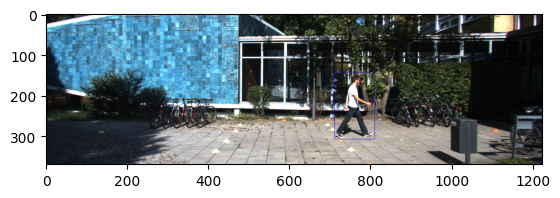

In [6]:
import cv2
import matplotlib.pyplot as plt


id = 0
img = cv2.imread(dataset_dicts[0]['file_name'])
xywh = dataset_dicts[0]['annotations'][0]['bbox']
def x1y1wh2xyxy(box):
    x1, y1, w, h = box
    x2, y2 = x1 + w, y1 + h
    return x1, y1, x2, y2

xyxy = x1y1wh2xyxy(xywh)
img = cv2.rectangle(img, (xyxy[0], xyxy[1]),
                    (xyxy[2], xyxy[3]), 
                    (255, 0, 0), 1)

plt.imshow(img[..., ::-1])


In [7]:
num_ins = 0

for i, img in enumerate(dataset_dicts):
    annots = dataset_dicts[i]['annotations']
    for annot in annots:
        num_ins += 1

In [8]:
len(dataset_dicts)

5984

In [9]:
num_ins

41322

In [10]:
size_range = (32 * 32, 96 * 96)

In [12]:
num_small_objs = num_med_objs = num_large_objs = 0

for i, img in enumerate(dataset_dicts):
    annots = dataset_dicts[i]['annotations']
    for annot in annots:
        _, _, w, h = annot['bbox']
        area = w * h
        if area < size_range[0]:
            num_small_objs += 1
        elif area >= size_range[1]:
            num_large_objs += 1
        else:
            num_med_objs += 1

assert num_small_objs + num_med_objs + num_large_objs == num_ins

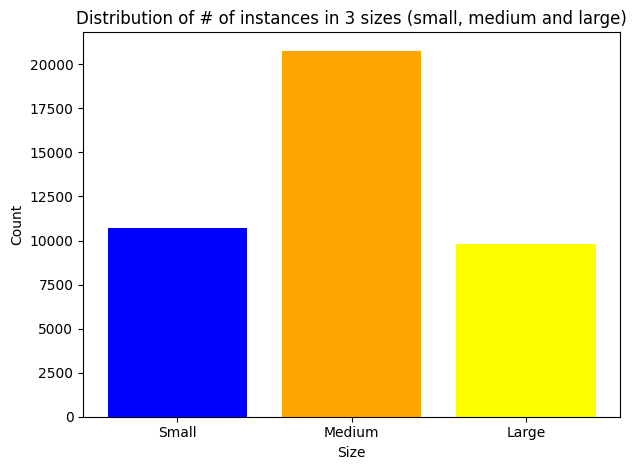

In [13]:
import matplotlib.pyplot as plt

categories = ['Small', 'Medium', 'Large']
values = [num_small_objs, num_med_objs, num_large_objs]
colors = ['blue', 'orange', 'yellow']  # Colors for each bar

plt.bar(categories, values, color=colors)

plt.title('Distribution of # of instances in 3 sizes (small, medium and large)')
plt.xlabel('Size')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [14]:
type(dataset_dicts)

list

## Count positive labels by Max-IOU

In [36]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load("khang_net/configs/yolof/yolof_resnet_50_1x.py")

cfg.dataloader.train.total_batch_size = 2
cfg.dataloader.mapper = None
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'
cfg.dataloader.train.shuffle = False
cfg.train.device = 'mps'

train_loader = instantiate(cfg.dataloader.train)
model = instantiate(cfg.model)

In [16]:
from detectron2.structures import ImageList
from khang_net.modeling.meta_arch.yolof import pairwise_iou
from tqdm import tqdm
import numpy as np
import torch

cnt = 0
num_ins = 0
size_range = (32 * 32, 96 * 96)
num_small_pos_labels = num_med_pos_labels = num_large_pos_labels = 0

for batch in tqdm(train_loader):
    if cnt == len(dataset_dicts):
        break    
    assert len(batch) == 1

    # Get instances 
    input = batch[0]
    gt_instances = input['instances']
    
    # Get anchors
    batch_size = 1
    h, w = 13, 42
    channels = 3
    features = torch.rand((batch_size, channels, h, w))
    anchors = model.anchor_generator(features)
    
    # Label assignment
    gt_labels, gt_boxes = model.label_anchors(anchors, [gt_instances])
    gt_labels, gt_boxes = gt_labels[0], gt_boxes[0]

    pos_mask = (gt_labels >= 0) & (gt_labels != 80)
    
    pos_boxes = gt_boxes[pos_mask]

    area = (pos_boxes[:, 2] - pos_boxes[:, 0]) * (pos_boxes[:, 3] - pos_boxes[:, 1])
    num_small = int(torch.sum(area < size_range[0]).item())
    num_med = int(torch.sum(torch.logical_and(area >= size_range[0], area < size_range[1])).item())
    num_large = int(torch.sum(area >= size_range[1]).item())

    assert num_small + num_med + num_large == pos_boxes.shape[0]
    
    num_small_pos_labels += num_small
    num_med_pos_labels += num_med
    num_large_pos_labels += num_large

    cnt += 1


#print(num_ins)

0it [00:00, ?it/s]/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
5984it [00:37, 161.66it/s]


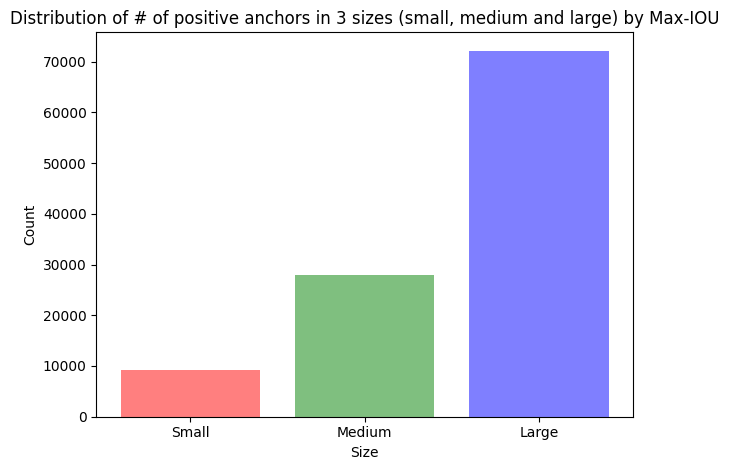

In [17]:
import matplotlib.pyplot as plt

categories = ['Small', 'Medium', 'Large']
values = [num_small_pos_labels, num_med_pos_labels, num_large_pos_labels]
colors = ['red', 'green', 'blue']  # Colors for each bar

plt.bar(categories, values, color=colors, alpha=0.5)

plt.title('Distribution of # of positive anchors in 3 sizes (small, medium and large) by Max-IOU')
plt.xlabel('Size')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [13]:
anchors

Boxes(tensor([[ -16.,  -16.,   16.,   16.],
        [ -32.,  -32.,   32.,   32.],
        [ -64.,  -64.,   64.,   64.],
        ...,
        [1248.,  320., 1376.,  448.],
        [1184.,  256., 1440.,  512.],
        [1056.,  128., 1568.,  640.]]))

In [24]:
from detectron2.structures import Boxes

In [18]:
anchors.tensor.shape

torch.Size([2730, 4])

In [30]:
import torch

batch_size = 2
h, w = 13, 42
channels = 3
features = torch.rand((batch_size, channels, h, w))
features = [features]

anchors = model.anchor_generator(features)

In [31]:
# def get_ground_truth
anchors = [Boxes.cat(anchors_i) for anchors_i in anchors]
N = len(anchors)
all_anchors = Boxes.cat(anchors).tensor.reshape(N, -1, 4)  # (B, R, 4), B = batch_size, R = #anchors_on_grid

In [41]:
# def get_ground_truth
batch = next(iter(train_loader))
gt_instances = [input['instances'] for input in batch]

In [54]:
pred_anchor_deltas = [torch.zeros((batch_size, h * w * 5, 4))]

In [57]:
from detectron2.layers import cat

box_delta = cat(pred_anchor_deltas, dim=1)

In [58]:
box_delta.shape

torch.Size([2, 2730, 4])

In [65]:
import math

def apply_deltas(deltas, boxes):
    """
    Apply transformation `deltas` (dx, dy, dw, dh) to `boxes`.

    Args:
        deltas (Tensor): transformation deltas of shape (N, k*4), where k >= 1.
            deltas[i] represents k potentially different class-specific
            box transformations for the single box boxes[i].
        boxes (Tensor): boxes to transform, of shape (N, 4)
    """
    assert torch.isfinite(
            deltas).all().item(), "Box regression deltas become infinite or NaN!"
    boxes = boxes.to(deltas.dtype)

    widths = boxes[..., 2] - boxes[..., 0]
    heights = boxes[..., 3] - boxes[..., 1]
    ctr_x = boxes[..., 0] + 0.5 * widths
    ctr_y = boxes[..., 1] + 0.5 * heights

    wx, wy, ww, wh = (1.0, 1.0, 1.0, 1.0)
    dx = deltas[..., 0::4] / wx
    dy = deltas[..., 1::4] / wy
    dw = deltas[..., 2::4] / ww
    dh = deltas[..., 3::4] / wh

    # Prevent sending too large values into torch.exp()
    dx_width = dx * widths[..., None]
    dy_height = dy * heights[..., None]
    add_ctr_clamp = True
    ctr_clamp = 32
    scale_clamp = math.log(1000.0 / 16)
    if add_ctr_clamp:
        dx_width = torch.clamp(dx_width,
                               max=ctr_clamp,
                               min=-ctr_clamp)
        dy_height = torch.clamp(dy_height,
                                max=ctr_clamp,
                                min=-ctr_clamp)
    dw = torch.clamp(dw, max=scale_clamp)
    dh = torch.clamp(dh, max=scale_clamp)

    pred_ctr_x = dx_width + ctr_x[..., None]
    pred_ctr_y = dy_height + ctr_y[..., None]
    pred_w = torch.exp(dw) * widths[..., None]
    pred_h = torch.exp(dh) * heights[..., None]

    pred_boxes = torch.zeros_like(deltas)
    pred_boxes[..., 0::4] = pred_ctr_x - 0.5 * pred_w  # x1
    pred_boxes[..., 1::4] = pred_ctr_y - 0.5 * pred_h  # y1
    pred_boxes[..., 2::4] = pred_ctr_x + 0.5 * pred_w  # x2
    pred_boxes[..., 3::4] = pred_ctr_y + 0.5 * pred_h  # y2
    return pred_boxes

In [66]:
print(all_anchors.shape)
print(box_delta.shape)

torch.Size([2, 2730, 4])
torch.Size([2, 2730, 4])


In [67]:
box_pred = apply_deltas(box_delta, all_anchors)

In [68]:
box_pred.shape

torch.Size([2, 2730, 4])

In [210]:
# Matcher
bs, num_queries = box_pred.shape[:2]  #B, R
out_bbox = box_pred.flatten(0, 1)  # (B x R, 4)
anchors = all_anchors.flatten(0, 1)  # (B x R, 4)

In [85]:
tgt_bbox = torch.cat([v.gt_boxes.tensor for v in gt_instances])  # (#total_ins_in_batch, 4)
assert len(tgt_bbox) == sum([len(v) for v in gt_instances])

In [98]:
def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

cost_bbox = torch.cdist(
            box_xyxy_to_cxcywh(out_bbox), box_xyxy_to_cxcywh(tgt_bbox), p=1)  # (B x R, #total_ins_in_batch)
cost_bbox_anchors = torch.cdist( 
            box_xyxy_to_cxcywh(anchors), box_xyxy_to_cxcywh(tgt_bbox), p=1)  # (B x R, #total_ins_in_batch)

In [99]:
# Final cost matrix
C = cost_bbox
C = C.view(bs, num_queries, -1)  # (B, R, #total_ins_in_batch)
C1 = cost_bbox_anchors
C1 = C1.view(bs, num_queries, -1)  # (B, R, #total_ins_in_batch)

In [104]:
sizes = [len(v.gt_boxes.tensor) for v in gt_instances]
all_indices_list = [[] for _ in range(bs)]

In [149]:
# positive indices when matching predict boxes and gt boxes
# len(indices) = B
# len(indices[i]) = topk
# len(indices[i][j]) = #num_ins_in_img

indices = [tuple(torch.topk(c[i], 
                            k=4, 
                            dim=0,
                            largest=False)[1].numpy().tolist()) for i, c in enumerate(C.split(sizes, -1))]

In [131]:
# positive indices when matching anchor boxes and gt boxes
indices1 = [tuple(torch.topk(c[i],
                            k=4,
                            dim=0,
                            largest=False)[1].numpy().tolist()) for i, c in enumerate(C1.split(sizes, -1))] 

In [176]:
import numpy as np

# concat the indices according to image ids
for img_id, (idx, idx1) in enumerate(zip(indices, indices1)):
    img_idx_i = [
        np.array(idx_ + idx1_) for (idx_, idx1_) in zip(idx, idx1)
    ]
    img_idx_j = [
        np.array(list(range(len(idx_))) + list(range(len(idx1_)))) for (idx_, idx1_) in zip(idx, idx1)
    ]
    all_indices_list[img_id] = [*zip(img_idx_i, img_idx_j)]
    break

In [280]:
# re-organize the positive indices
all_indices = []
for img_id in range(bs):
    all_idx_i = []
    all_idx_j = []
    for idx_list in all_indices_list[img_id]:
        idx_i, idx_j = idx_list
        all_idx_i.append(idx_i)
        all_idx_j.append(idx_j)
    all_idx_i = np.hstack(all_idx_i)
    all_idx_j = np.hstack(all_idx_j)
    all_indices.append((all_idx_i, all_idx_j))
    rs= [
        (torch.as_tensor(i, dtype=torch.int64),
         torch.as_tensor(j, dtype=torch.int64))
         for i, j in all_indices
    ]

In [196]:
all_indices

[(array([1380, 1355, 1380, 1355, 1385, 1350, 1385, 1350, 1381, 1145, 1381,
         1145, 1590, 1360, 1590, 1360]),
  array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])),
 (array([2258, 1807, 1581, 1335, 1330, 1320, 2258, 1807, 1581, 1335, 1330,
         1320, 2263, 1812, 1791, 1545, 1325, 1110, 2263, 1812, 1791, 1545,
         1325, 1110, 2048, 2017, 1586, 1330, 1540, 1325, 2048, 2017, 1586,
         1330, 1540, 1325, 2053, 1802, 1576, 1336, 1335, 1315, 2053, 1802,
         1576, 1336, 1335, 1315]),
  array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
         4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
         2, 3, 4, 5]))]

In [281]:
# loss

batch_size = 2
h, w = 13, 42
num_classes = 80

indices = rs
gt_instances = gt_instances
anchors = model.anchor_generator(features)
pred_anchor_deltas = [torch.zeros((batch_size, h * w * 5, 4))]
pred_logits = [torch.zeros((batch_size, h * w * 5, num_classes))]

In [282]:
pred_class_logits = cat(pred_logits, dim=1).view(-1, num_classes)  # (BxR, #classes)
pred_anchor_deltas = cat(pred_anchor_deltas, dim=1).view(-1, 4)  # (BxR, 4)
anchors = [Boxes.cat(anchors_i) for anchors_i in anchors]  # (B, R, 4)
N = len(anchors)
all_anchors = Boxes.cat(anchors).tensor  # (BxR, 4)

In [283]:
predicted_boxes = apply_deltas(pred_anchor_deltas, all_anchors)
predicted_boxes = predicted_boxes.reshape(N, -1, 4)  # (B, R, 4)

In [284]:
from torchvision.ops.boxes import box_area

def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

ious, pos_ious = [], []
for i in range(N):
    src_idx, tgt_idx = indices[i]
    iou, _ = box_iou(predicted_boxes[i, ...],
                     gt_instances[i].gt_boxes.tensor)
    if iou.numel() == 0:
        max_iou = iou.new_full((iou.size(0),), 0)
    else:
        max_iou = iou.max(dim=1)[0]

    a_iou, _ = box_iou(anchors[i].tensor,
                       gt_instances[i].gt_boxes.tensor)
    if a_iou.numel() == 0:
        pos_iou = a_iou.new_full((0,), 0)
    else:
        pos_iou = a_iou[src_idx, tgt_idx]
    
    ious.append(max_iou)  
    pos_ious.append(pos_iou)

In [285]:
POS_IGNORE_THRESHOLD = 0.15
NEG_IGNORE_THRESHOLD = 0.7

ious = torch.cat(ious)  # (BxR)
pos_ious = torch.cat(pos_ious)  # (sum(#ins_img_i * topk * 2)), sum over images in batch

In [329]:
ignore_idx = ious > NEG_IGNORE_THRESHOLD
pos_ignore_idx = pos_ious < POS_IGNORE_THRESHOLD

In [330]:
src_idx = torch.cat(
    [src + idx * anchors[0].tensor.shape[0] for idx, (src, _) in enumerate(indices)
])

In [331]:
gt_classes = torch.full(pred_class_logits.shape[:1],
                        num_classes,
                        dtype=torch.int64)

In [332]:
gt_classes[ignore_idx] = -1
target_classes_o = torch.cat(
    [t.gt_classes[J] for t, (_, J) in zip(gt_instances, indices)]
)

In [333]:
target_classes_o[pos_ignore_idx] = -1
gt_classes[src_idx] = target_classes_o

In [334]:
valid_idxs = gt_classes >= 0
foreground_idxs = (gt_classes >= 0) & (gt_classes != num_classes)
num_foreground = foreground_idxs.sum()

In [311]:
(gt_classes >= 0) & (gt_classes != num_classes)

tensor([False, False, False,  ..., False, False, False])

In [325]:
target_classes_o = torch.cat(
    [t.gt_classes[J] for t, (_, J) in zip(gt_instances, indices)]
)

In [327]:
target_classes_o

tensor([7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7,
        7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7,
        7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1])

In [346]:
gt_classes_target = torch.zeros_like(pred_class_logits)
gt_classes_target[foreground_idxs, gt_classes[foreground_idxs]] = 1

In [348]:
pred_class_logits.shape

torch.Size([5460, 80])

In [349]:
gt_classes_target.shape

torch.Size([5460, 80])

In [350]:
# reg loss
target_boxes = torch.cat(
    [t.gt_boxes.tensor[i] for t, (_, i) in zip(gt_instances, indices)],
    dim=0)

In [352]:
target_boxes.shape

torch.Size([64, 4])

In [367]:
target_boxes = target_boxes[~pos_ignore_idx]

In [362]:
matched_predicted_boxes = predicted_boxes.reshape(-1, 4)[src_idx[~pos_ignore_idx]]

In [364]:
def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

In [365]:
matched_predicted_boxes.shape

torch.Size([42, 4])

In [368]:
target_boxes.shape

torch.Size([42, 4])

In [372]:
(1 - torch.diag(generalized_box_iou(matched_predicted_boxes, target_boxes))).sum()

tensor(26.7916)